In [ ]:
import numpy as np
import xarray as xr
import boule as bl

In [ ]:
import importlib
import functions as md

importlib.reload(md)  # Reload the module

print(md.__file__)

In [ ]:
# Constante do GRS80

ellipsoid = bl.GRS80
first_eccentricity = ellipsoid.first_eccentricity
print(f"first_eccentricity: {first_eccentricity}")

first_ecc_sq = first_eccentricity**2
print(f"first_ecc_sq: {first_ecc_sq}")

In [ ]:
# Importando o MDE

geotiff_path = '../data/MDS_MERIT_SRTM15PLUS_900m_fill.tif'
elevation = md.geotiff_to_dataarray(geotiff_path)
elevation = elevation.rename({'x': 'longitude', 'y': 'latitude'})

md.plot_DataArray_percentiles(
    elevation, 
    x='longitude', 
    y='latitude', 
    label='unit', 
    title='DataArray_percentiles', 
    cmap='magma', 
    num_classes=10
    )

In [ ]:
# Geodetic coordinates of point P in degrees
latP = -(25 + 26/60 + 54.12695/3600)
longP = -(49 + 13/60 + 51.43717/3600)

# Convert to radians
latP_rad = np.deg2rad(latP)
longP_rad = np.deg2rad(longP)
lat_grid_rad = np.deg2rad(elevation["latitude"].values)
lon_grid_rad = np.deg2rad(elevation["longitude"].values)

# Create 2D meshgrid of coordinates
lon_grid, lat_grid = np.meshgrid(lon_grid_rad, lat_grid_rad)

# Convert geodetic to geocentric latitudes
latP_geoc = np.arctan((1 - first_ecc_sq) * np.tan(latP_rad))
lat_grid_geoc = np.arctan((1 - first_ecc_sq) * np.tan(lat_grid))

# Compute spherical distance (central angle ψ) using spherical law of cosines
cos_sigma = (
    np.sin(latP_geoc) * np.sin(lat_grid_geoc) +
    np.cos(latP_geoc) * np.cos(lat_grid_geoc) * np.cos(lon_grid - longP_rad)
)

# Clamp to [-1, 1] to avoid domain errors in arccos due to numerical precision
cos_sigma = np.clip(cos_sigma, -1.0, 1.0)
psi = np.arccos(cos_sigma)

# Compute terms of the Stokes function
half_psi = psi / 2
sin_half_psi = np.sin(half_psi)
cos_psi = np.cos(psi)

term1 = 1 / sin_half_psi
term2 = 6 * sin_half_psi
term3 = 5 * cos_psi
term4 = 3 * cos_psi * np.log(sin_half_psi**2 + sin_half_psi)  
term5 = sin_half_psi

# Final expression of the Stokes function
S_psi = term1 - term2 + 1 - term3 - term4 + term5
S_psi

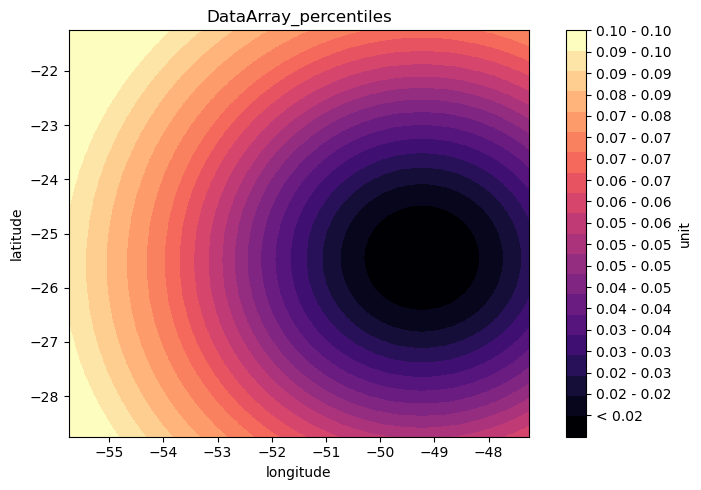

In [30]:
lon_grid, lat_grid = np.meshgrid(elevation["longitude"].values, elevation["latitude"].values)

latP_rad = np.deg2rad(latP)
longP_rad = np.deg2rad(longP)
lat_grid_rad = np.deg2rad(lat_grid)
lon_grid_rad = np.deg2rad(lon_grid)

latP_geoc_rad = np.arctan((1 - first_ecc_sq) * np.tan(latP_rad))
lat_grid_geoc_rad = np.arctan((1 - first_ecc_sq) * np.tan(lat_grid_rad))

cos_sigma = (
        np.sin(latP_geoc_rad) * np.sin(lat_grid_geoc_rad) +
        np.cos(latP_geoc_rad) * np.cos(lat_grid_geoc_rad) * np.cos(lon_grid_rad - longP_rad)
    )

psi = np.arccos(cos_sigma)

unique_x = np.unique(lon_grid[0, :])
unique_y = np.unique(lat_grid[:, 0])

psi_da = xr.DataArray(
    psi,
    coords={
        "latitude": unique_y,
        "longitude": unique_x
    },
    dims=("latitude", "longitude")
)
psi_da.name = "psi"

md.plot_DataArray_percentiles(
    psi_da, 
    x='longitude', 
    y='latitude', 
    label='unit', 
    title='DataArray_percentiles', 
    cmap='magma', 
    num_classes=20
    )

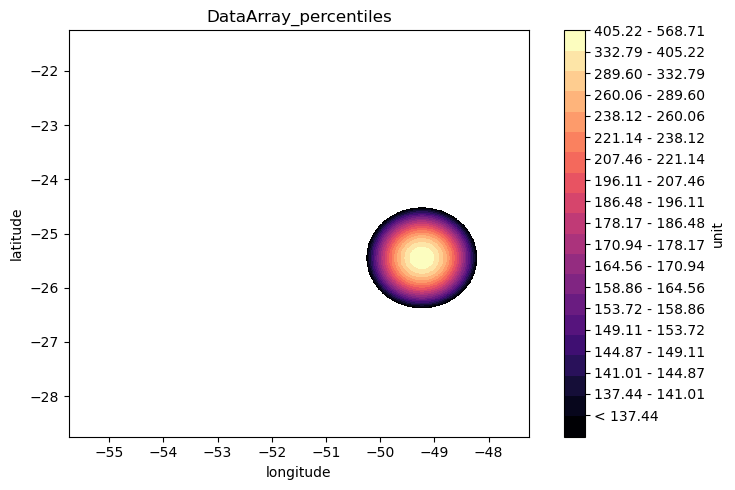

In [32]:
# Define integration radius (100 km)
raio_integracao = 100_000  # in meters
raio_integracao_graus = raio_integracao / 108_000  # approx: 1" ≈ 30 m
raio_integracao_rad = np.deg2rad(raio_integracao_graus)

# Compute terms of the Stokes function
half_psi = psi / 2
sin_half_psi = np.sin(half_psi)
cos_psi = np.cos(psi)

term1 = 1 / sin_half_psi
term2 = 6 * sin_half_psi
term3 = 5 * cos_psi
term4 = 3 * cos_psi * np.log(sin_half_psi**2 + sin_half_psi)  # melhora a estabilidade numérica
term5 = sin_half_psi

# Evaluate full Stokes function only within integration radius
S_psi = xr.where(
    psi_da <= raio_integracao_rad,
    term1 - term2 + 1 - term3 - term4 + term5,
    np.nan
)

md.plot_DataArray_percentiles(
    S_psi, 
    x='longitude', 
    y='latitude', 
    label='unit', 
    title='DataArray_percentiles', 
    cmap='magma', 
    num_classes=20
    )

In [ ]:
# Calculate resolution in degrees along the longitude and latitude directions
res_longitude = np.mean(np.abs(np.diff(elevation.coords['longitude'].values)))
res_latitude = np.mean(np.abs(np.diff(elevation.coords['latitude'].values)))
res = np.median([res_longitude, res_latitude]) # Resolução em °
res_rad = np.deg2rad(res)

In [ ]:
# Coordenadas do ponto de cálculo
latP = - (25 + 26/60 + 54.12695/3600) # em graus decimais
longP = - (49 + 13/60 + 51.43717/3600) # m graus decimais

elevationP = elevation.sel(
    latitude=latP, 
    longitude=longP, 
    method="nearest"
    ).values # HP extraído do MDS



print(f"Latitude: {latP}°")
print(f"Longitude: {longP}°")
print(f"elevationP: {elevationP}m")

In [ ]:
# Calculate resolution in degrees along the longitude and latitude directions
res_longitude = np.mean(np.abs(np.diff(elevation.coords['longitude'].values)))
res_latitude = np.mean(np.abs(np.diff(elevation.coords['latitude'].values)))
res = np.median([res_longitude, res_latitude]) # Resolução em °
res_rad = np.deg2rad(res)
raio_integracao = 100000
raio_graus=raio_integracao/108000 # raio em graus utilizando a relação 1"=30 m
raio_rad = np.deg2rad(raio_graus)

In [ ]:
# Criar a grade de coordenadas (equivalente ao broadcast)
lon_grid, lat_grid = np.meshgrid(elevation["longitude"].values, elevation["latitude"].values)

# Calcular deltas em metros (assumindo 1'' = 30m em ambas as direções)
delta_lat = (lat_grid - latP) * 3600 * 30  # em metros
delta_lon = (lon_grid - longP) * 3600 * 30  # em metros

# Distância horizontal r
distance = np.sqrt(delta_lat**2 + delta_lon**2)

unique_x = np.unique(lon_grid[0, :])
unique_y = np.unique(lat_grid[:, 0])

distance = xr.DataArray(
    distance,
    coords={
        "latitude": unique_y,
        "longitude": unique_x
    },
    dims=("latitude", "longitude")
)
distance.name = "distance"

distance = distance.interp_like(elevation)

md.plot_DataArray_percentiles(
    distance, 
    x='longitude', 
    y='latitude', 
    label='unit', 
    title='DataArray_percentiles', 
    cmap='magma', 
    num_classes=20
    )

In [ ]:
gravity_equator = ellipsoid.gravity_equator
print(gravity_equator)

In [ ]:
sin_half = np.sin(psi / 2)
cos_psi = np.cos(psi)


S_psi = (1 / sin_half) - 6 * sin_half + 1 - 5 * cos_psi - 3 * cos_psi * np.log(sin_half**2 + sin_half)

In [ ]:
latP = - (25 + 26/60 + 54.12695/3600) # em graus decimais
longP = - (49 + 13/60 + 51.43717/3600) # m graus decimais
semimajor_axis = ellipsoid.semimajor_axis

elevationP = elevation.sel(
    latitude=latP, 
    longitude=longP, 
    method="nearest"
    ).values # HP extraído do MDS

_, lat_geoc, _ = ellipsoid.geodetic_to_spherical(
        longP, latP, 0
    )

print(f"Latitude: {latP}°")
print(f"Longitude: {longP}°")
print(f"lat_geoc: {lat_geoc}°")
print(f"elevationP: {elevationP}m")

In [ ]:
def angular_distance_grid(phi0, lambda0, phi_grid, lambda_grid):
    # Ensure all angles are in radians
    phi0 = np.radians(phi0)
    lambda0 = np.radians(lambda0)
    phi_grid = np.radians(phi_grid)
    lambda_grid = np.radians(lambda_grid)

    # Apply spherical law of cosines
    cos_sigma = (
        np.sin(phi0) * np.sin(phi_grid) +
        np.cos(phi0) * np.cos(phi_grid) * np.cos(lambda_grid - lambda0)
    )

    # Numerical stability: ensure result is in [-1, 1]
    cos_sigma = np.clip(cos_sigma, -1.0, 1.0)

    # Return angular distance (in radians)
    return np.arccos(cos_sigma)


In [ ]:
# Criar a grade de coordenadas (equivalente ao broadcast)
lon_grid, lat_grid = np.meshgrid(elevation["longitude"].values, elevation["latitude"].values)


lon_sph, lat_sph, r_sph = ellipsoid.geodetic_to_spherical(
    lon_grid, lat_grid, 0
)




In [ ]:
# Supondo que 'elevation' já seja um DataArray com dims ('latitude', 'longitude')
lat_grid, lon_grid = np.meshgrid(
    elevation["latitude"].values,
    elevation["longitude"].values,
    indexing="ij"
)

# Converte coordenadas geodésicas para esféricas
lon_sph, lat_sph, r_sph = ellipsoid.geodetic_to_spherical(
    lon_grid, lat_grid, semimajor_axis
)

# Ponto fixo de referência (em graus)
latP = -25.0
longP = -50.0

# Calcula a distância angular (em radianos)
angular_distance = angular_distance_grid(latP, longP, lat_sph, lon_sph)

unique_x = np.unique(lon_sph[0, :])
unique_y = np.unique(lat_sph[:, 0])

angular_distance_da = xr.DataArray(
    angular_distance,
    coords={"latitude": elevation.latitude, "longitude": elevation.longitude},
    dims=("latitude", "longitude")
)
angular_distance_da.name = "angular_distance"

In [ ]:
md.plot_DataArray_percentiles(
    angular_distance_da, 
    x='longitude', 
    y='latitude', 
    label='unit', 
    title='DataArray_percentiles', 
    cmap='magma', 
    num_classes=20
    )

In [ ]:
# Transforma em DataArray com as mesmas coordenadas do original
angular_distance_da = xr.DataArray(
    data=angular_distance,
    dims=["latitude", "longitude"],
    coords={"latitude": elevation.latitude, "longitude": elevation.longitude},
    name="angular_distance"
)

In [ ]:
# Criar a grade de coordenadas (equivalente ao broadcast)
lon_grid, lat_grid = np.meshgrid(elevation["longitude"].values, lat_geoc)

# Calcular deltas em metros (assumindo 1'' = 30m em ambas as direções)
delta_lat = (lat_grid - latP) #* 3600 * 30  # em metros
delta_lon = (lon_grid - longP) #* 3600 * 30  # em metros

# Distância horizontal r
angular_distance = angular_distance_grid(latP, longP, lat_sph, lon_sph)


unique_x = np.unique(lon_grid[0, :])
unique_y = np.unique(lat_grid[:, 0])

distance = xr.DataArray(
    distance,
    coords={
        "latitude": unique_y,
        "longitude": unique_x
    },
    dims=("latitude", "longitude")
)
distance.name = "distance"

distance = distance.interp_like(elevation)

md.plot_DataArray_percentiles(
    distance, 
    x='longitude', 
    y='latitude', 
    label='unit', 
    title='DataArray_percentiles', 
    cmap='magma', 
    num_classes=20
    )

In [ ]:


print(f"lat_geoc: {lat_geoc}°")

In [ ]:
print(radius)